# Lab Sheet 4-5 - Solutions: Extra Task - full 20 Newsgroups

These are the solutions for the extra task, multi-class classification on the full 20 newgroups.

There are a few new things here: 
- We need to use Multi-class classifiers and evaluators, see below for details.
- I've organised the labelling differently, using a dictionary. 
- We need to specift the types of the columns, because the lables need to be numeric.
- We need to reduce the size of the data and the running time of the training to make sure first that everything works. Once we know we can then switch to the full version. Look for the lines starting with `# REDUCED` and `# FULL` to switch from the reduced version to the full one. 
- I've  included saving RDDs and DataFrames to files and reading them back (in pickle and parquet format). Reading from small files and transforming can take a long time, so that saving the results is useful to avoid having to redo the processing.
- I've also added a good number of `%time` commands to measure execution time. Note the differences between CPU Time and Wall Time.


# Preparation and troubleshooting
Like in the main lab, we need to get the data. If you haven't got the data yet, uncomment the four cells below and run them once.

In [2]:
#%cd ~/notebook/work/City-Data-Science/datasets/
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz
#!ls

In [3]:
#!tar -xf 20_newsgroups.tar.gz
# '!' calls a program on the machine (the DSX service runs on virtual Linux machines).
#print(">>> Unzipping finished.")

In [4]:
#!echo "datasets/20_newsgroups/**" >> ~/notebook/work/City-Data-Science/.git/info/exclude
# add the newly created directory to the list of excluded dirs to prevent accidental uploading to github
# do this only once

In [5]:
# go into the new directory
#%cd ./20_newsgroups/ 
#%ls # and show its content

The cell below is for deleting the metastore_db, if that error occurs. 

In [6]:
#!rm -R <...metastore_db>

# 1) Loading the data
The loading process is a bit different, as we now want to get all classes, not just 2. For this we will create a dictionary of topic names to class labels (as numbers), that we can use for the classifier.

A new part is that we add labels using the ditionary created above. See here for how to create and use dictionaries: [https://docs.python.org/3/library/stdtypes.html#typesmapping](https://docs.python.org/3/library/stdtypes.html#typesmapping).

Try getting everything to work with the REDUCED version first, then switch to the FULL version.

In [20]:
from pyspark.ml import *
from pyspark.sql import *

from pyspark.sql.types import Row
from pyspark.sql import SQLContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

import os.path

%cd ~
p = os.path.abspath('./notebook/work/City-Data-Science/datasets/20_newsgroups/')
# we need the absolute path, as the executors that will read the from directories, will not run in the same environment, so that %cd calls don't help
print("p: ", p) 

# Create a dictionary for class labels (from the directory names)
topicLabels = {}
import os
label = 0
# we iterate through the data directories 
for root, dirs, files in os.walk(p, topdown=False):
    for name in dirs:
        topicLabels[name] = label # and assign a label number to each
        label = label + 1 # and increment the label number

print(topicLabels)

# Load the data into RDDs
# REDUCED  the first version below only loads the 4 'rec....' topics, use the second to get the full set. 
#>>> %time newsGroup_RDD = sc.wholeTextFiles(p + ... ) # use a glob expression that catches only the directories starting with rec 
#%time newsGroup_RDD = sc.wholeTextFiles(p + '/rec*') 
# FULL use all topics
%time newsGroup_RDD = sc.wholeTextFiles(p + '/*') 

#print the total number of documents here (2000 for *comp.sys*, 20000 for the full set):
#print ('Number of documents read is:',newsGroup_RDD.count())
%time newsGroup_RDD.take(1)

/gpfs/global_fs01/sym_shared/YPProdSpark/user/s832-dfe96c6e1f1d61-70d619a53771
p:  /gpfs/global_fs01/sym_shared/YPProdSpark/user/s832-dfe96c6e1f1d61-70d619a53771/notebook/work/City-Data-Science/datasets/20_newsgroups
{'rec.sport.baseball': 7, 'sci.space': 11, 'talk.religion.misc': 15, 'comp.sys.mac.hardware': 14, 'misc.forsale': 13, 'alt.atheism': 0, 'sci.electronics': 6, 'talk.politics.misc': 18, 'rec.sport.hockey': 8, 'rec.autos': 2, 'rec.motorcycles': 4, 'sci.crypt': 16, 'comp.windows.x': 12, 'talk.politics.guns': 5, 'comp.graphics': 10, 'talk.politics.mideast': 1, 'soc.religion.christian': 19, 'comp.sys.ibm.pc.hardware': 17, 'comp.os.ms-windows.misc': 3, 'sci.med': 9}
CPU times: user 0 ns, sys: 795 µs, total: 795 µs
Wall time: 30.7 ms
CPU times: user 102 ms, sys: 75.3 ms, total: 178 ms
Wall time: 9min 11s


[('file:/gpfs/global_fs01/sym_shared/YPProdSpark/user/s832-dfe96c6e1f1d61-70d619a53771/notebook/work/City-Data-Science/datasets/20_newsgroups/alt.atheism/53400',
  'Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!bogus.sura.net!news-feed-1.peachnet.edu!umn.edu!uum1!mac.cc.macalstr.edu!acooper\nFrom: acooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery)\nNewsgroups: alt.atheism\nSubject: Re: free moral agency\nMessage-ID: <1993Apr20.185237.4924@mac.cc.macalstr.edu>\nDate: 20 Apr 93 18:52:37 -0600\nReferences: <1quuaa$6s@eagle.lerc.nasa.gov> <735295730.25282@minster.york.ac.uk>\nDistribution: world\nOrganization: Macalester College\nLines: 19\n\nIn article <735295730.25282@minster.york.ac.uk>, cjhs@minster.york.ac.uk writes:\n> : Are you saying that their was a physical Adam and Eve, and that all\n> : humans are direct decendents of only these two human beings.?  Then who\

### Comment 
You can see a significant difference between the time for `wholeTextFiles` and `take`. This is because only an *action* actually triggers the execution. 

Try getting everything to work with the REDUCED version first, then switch to the FULL version.

# 2) Remove the headers,  prepare the topics and the labels
As in the main lab, we need to remove these headers and from the file paths, we keep only the topics (newsgroup names). 

In addition we add lables, using the topicLabels dictionary. See here for how to create and use dictionaries: [https://docs.python.org/3/library/stdtypes.html#typesmapping](https://docs.python.org/3/library/stdtypes.html#typesmapping).

Finally, we save the processed RDD in pickle format (creates a directory of files). This throws and error if the directory exists, read the instructions below.

In [21]:
import re

# new function to remove the headers using regular expressions
def removeHeader(ft): 
    fn,text = ft # unpack the filename and text content 
    matchObj = re.match(r'.+^Lines:(.*)', text,re.DOTALL|re.MULTILINE) 
    if(matchObj): # only if the pattern has matched 
        text = matchObj.group(1) # can we replace the text, 
    return (fn,text)

ft_RDD = newsGroup_RDD.map(removeHeader)

# Remove the path before the last directory name and the file name after (i.e. leave the directory names, which are the newsgroup topics) 
tt_RDD = ft_RDD.map(lambda ft: (re.split('[/]',ft[0])[-2],ft[1]))
# Now add the topic numbers as labels
#>>> add the labels, but adding a third component to each element. 
# This third element is determined by reading the label from the topicLabels dictionary, using the topic string (first in the RDD elements) as key.
#>>> ttl_RDD = tt_RDD.map(lambda ...)
ttl_RDD = tt_RDD.map(lambda ft: (ft[0],ft[1],topicLabels[ft[0]]))

# and show an example result
print(ttl_RDD.take(1))
# it should contain [('topic name', 'text', labelNumber)]

# Reading and preparing the RDD can take some time, so saving it in a file for later use is a good idea. 
ttl_RDD.saveAsPickleFile('ttl_RDD_full.pkl')
# WARNING: this method will THROW AN ERROR IF THE FILE/DIRECTORY EXISTS
# It's a good idea tho change the name once you switch to FULL, so that you keep both versions
# If you are happy with the data you have, you can just comment out the code above

# To delete the directory use the following line
# %rm -Rf ~/notebook/work/ttl_RDD.pkl
# and 
# %ls -lh ~/notebook/work
# to check that it's gone

## 3) DataFrames

In this section we will introduce Dataframes as before. 

The main difference is that we treat the labels differently. In the previous version we generated the labels with `df.withColumn()`, which created them as a numeric type automaticaly. Here we have created them already in the RDDs and need to set the schema so that a numeric column will be created. 

Here are links to the docs on StructField, DataType (needed to define the column types), and StructType:
[http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.types.StructField](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.types.StructField)

[http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.types.DataType](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.types.DataType)

[http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.types.StructType](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.types.StructType)

We create three colums (topic, text, label), the first two as strings, the last as integer.

Like the RDDs, we also save the DataFrames for further use. For DataFramew we use the Parquet format, which is an efficient format for storing large structured data. For more information see [http://parquet.apache.org](http://parquet.apache.org). 


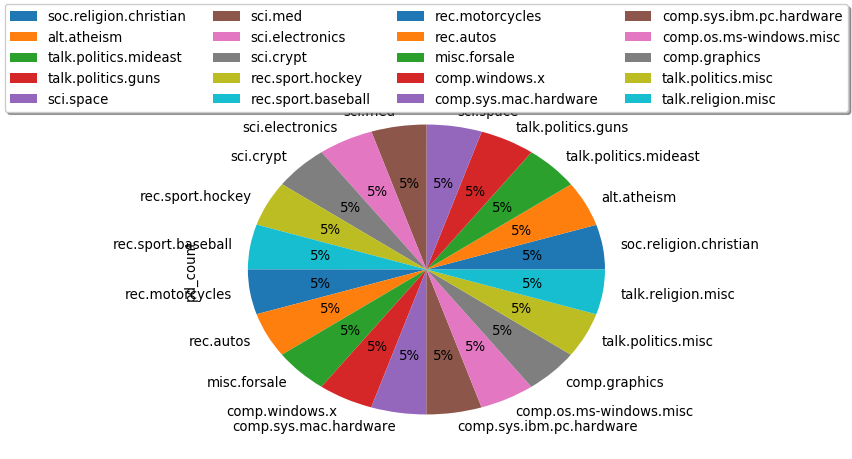

In [11]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# The schema is represented as a StructField object that comprises three fields, name (a string), dataType (a DataType) and nullable (a bool). 
# We create 3 fields of names and types according to our data: two strings, one integer for thelabel. 
fields = [] 
fields.append(StructField('topic', StringType(), True))
#>>> now do the same for 'text' instead of topic:
fields.append(StructField('text', StringType(), True))
#>>> and now for 'label' with type IntegerType instead of StringType:
fields.append(StructField('label', IntegerType(), True))

# these together define our schema
schema = StructType(fields)

# If you want to use a previously saved RDD, load it like this
ttl_RDD = sc.pickleFile('ttl_RDD_full.pkl')
# Apply the schema in createDataFrame, to create a DataFrame 'df' from the RDD
df = sqlContext.createDataFrame(ttl_RDD, schema)

#print the schema of our DataFrame
df.printSchema()


#Use pixiedust to show the data by topic
import pixiedust
display(df.select('topic'))# you can switch to bar or pie charts or other presentations 

# 4) Create training and test set

The dataframe can be split into train and test set. For testing purposes, we can also downsample.

Then we create a random split into training and test set. The test and tratining sets will be used multiple times, therefore caching is helpful to speed things up. A call to `DataFrame.cache()` is shorthand for `DataFrame.persist(MEMORY_AND_DISK)` used in the cell after the next. For information on persistence and StorageLevels see here: 
[http://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence](http://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence) 
and here:
[http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.StorageLevel](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.StorageLevel)
These StorageLevels levels apply to RDDs and DataFrames. 


In [37]:
# REDUCED Downsample the data for testing
#df2 = df.sample(False,0.1)
# FULL keep all data when ready
df2 = df

# It's useful to save this Dataframe, but once the file exists, the method will throw an error.
#df.write.parquet('df_full.pqt') 

#Create the training and testing set from the dataframe above
#randomSplit - splits the Df into training/testing using the weights 
#you can try other combinations of weights
train_set, test_set = df2.randomSplit([0.8, 0.2])

# cache() makes sure the sets are stored in memory or disk, rather than re-computed.
train_set.cache()
test_set.cache()
train_set.write.parquet('train_set.pqt')
test_set.write.parquet('test_set.pqt')

#>>> print the counts of training ans test set and time the execution with the %time magic
%time print ("Training-set count:",train_set.count())
%time print ("Test-set count:",test_set.count())
train_set

Training-set count: 16015
CPU times: user 1.63 ms, sys: 1.38 ms, total: 3.01 ms
Wall time: 320 ms
Test-set count: 3982
CPU times: user 2.5 ms, sys: 267 µs, total: 2.76 ms
Wall time: 65.1 ms


DataFrame[topic: string, text: string, label: int]

# When the previous steps are done, you can start from here the next time.

Once the above has been executed, you can use the cell below to load the prepared data, which is much faster. 
You will need to store new files (you can use different names) to switch from the REDUCED to the FULL dataset. 

In [1]:
%%time 
# Time the execution for the whole cell (except the first line)
%cd ~/notebook/work/
df = spark.read.parquet('df.pqt')
train_set = spark.read.parquet('train_set.pqt')
test_set = spark.read.parquet('test_set.pqt')
print("+++ all DataFrames loaded +++")

# make sure that the test and training sets are cached, equvalent to cache()
train_set.persist(StorageLevel.MEMORY_AND_DISK)
test_set.persist(StorageLevel.MEMORY_AND_DISK)

## 4) Using ML to classify messages 

We now use an ML Pipeline, but with MultiClass classifier and evaluator. 

We use DecisionTreeClassifier as it can deal with multiple classes out of the box and tends to work well on multiclass problems. We also use LogisticRegression, which comes with a multinomial implementation in Spark. Interestingly, it performs substantially worse in my experiments on this dataset. 
We can also use any binary classifier that outputs probabilities with the OneVsAll class:
[http://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.classification.OneVsRest](http://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.classification.OneVsRest)
    
To read more on Spark ML:
[https://spark.apache.org/docs/2.1.0/ml-features.html](https://spark.apache.org/docs/2.1.0/ml-features.html)
 
NOTE: The Spark `RandomForestClassifier` gives the best results on a full dataset, but crashes on small datasets in CV/TV validation. Feel free to play around with it, but be aware. This occasionally also happens for `DecisionTreeClassifier`. This is a know error in Spark 2.1.0:[https://issues.apache.org/jira/browse/SPARK-18036](https://issues.apache.org/jira/browse/SPARK-18036).
If you encounter this error ( I'll contain this "Py4JJavaError: \[...\] java.lang.UnsupportedOperationException: empty.maxBy"), the best option is to use a larger dataset (more samples or more classes).

Alternatively, try LogisticRegression, but it's doesn't perform well in this case.

In [ ]:
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF,StopWordsRemover,IDF,Tokenizer

#Constructing a pipeline
#We split each sentence into words using Tokenizer. 
#Tokenizer only splits by white spaces
tokenizer = Tokenizer().setInputCol("text").setOutputCol("words")

#Remove stopwords
remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)

#For each sentence (bag of words),use HashingTF to hash the sentence into a feature vector. 
hashingTF = HashingTF().setNumFeatures(1000).setInputCol("filtered").setOutputCol("rawFeatures")

#We use IDF to rescale the feature vectors; this generally improves performance when using text as features.
idf = IDF().setInputCol("rawFeatures").setOutputCol("features").setMinDocFreq(0)

#Our feature vectors could then be passed to a learning algorithm.
# REDUCED
cf = DecisionTreeClassifier()
# FULL
# cf = LogisticRegression()
# or
#cf = RandomForestClassifier()
# WARNING: The RandomForestClassifier tends to crash in the CV/TV validation with small numbers of classes, it works fine on the full dataset.

#Then we connect all the steps above to create one pipeline:
pipeline=Pipeline(stages=[tokenizer,remover,hashingTF,idf, cf])
print ("Pipeline:",pipeline.explainParams())

In [3]:
#We can get information for each parameter  using the .explainParams()
print ("Tokenizer:",tokenizer.explainParams())
print("\n\n")
print ("Remover:",remover.explainParams())
print("\n\n")
print ("HashingTF:",hashingTF.explainParams())
print ("\n\n")
print ("IDF:",idf.explainParams())
print ("\n\n")
print ("classifier:",cf.explainParams())

Tokenizer: inputCol: input column name. (current: text)
outputCol: output column name. (default: Tokenizer_48429fb56cbbca178238__output, current: words)



Remover: caseSensitive: whether to do a case sensitive comparison over the stop words (default: False, current: False)
inputCol: input column name. (current: words)
outputCol: output column name. (default: StopWordsRemover_4979a532d8a4fdb5cac5__output, current: filtered)
stopWords: The words to be filtered out (default: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at'

In [4]:
# After we construct this ML pipeline,we can fit it to the training data
# and obtain a trained pipeline model that can be used for prediction.
%time model=pipeline.fit(train_set)

CPU times: user 58 ms, sys: 18.1 ms, total: 76.1 ms
Wall time: 33 s


## 5) Evaluate prediction results

In [5]:
#After we obtain a fitted pipeline model, we want to know how well it performs. 
#Let us start with some manual checks by displaying the predicted labels.

#You can simply use the .transform() on the test set to make predictions on the test set
test_predictions = model.transform(test_set)
train_predictions = model.transform(train_set)

#Show the predicted labels along with true labels and raw texts.
test_predictions.select("topic","prediction","label").filter(test_predictions.topic.like("%hockey%")).show(5)
# and show some of the other class ...
test_predictions.select("topic","prediction","label").filter(test_predictions.topic.like("%baseball%")).show(5)

+----------------+----------+-----+
|           topic|prediction|label|
+----------------+----------+-----+
|rec.sport.hockey|      13.0|    8|
|rec.sport.hockey|       8.0|    8|
|rec.sport.hockey|       8.0|    8|
|rec.sport.hockey|      13.0|    8|
|rec.sport.hockey|       4.0|    8|
+----------------+----------+-----+
only showing top 5 rows

+------------------+----------+-----+
|             topic|prediction|label|
+------------------+----------+-----+
|rec.sport.baseball|      13.0|    7|
|rec.sport.baseball|      13.0|    7|
|rec.sport.baseball|       3.0|    7|
|rec.sport.baseball|      13.0|    7|
|rec.sport.baseball|       0.0|    7|
+------------------+----------+-----+
only showing top 5 rows



The predicted labels give as an intuition of what is going on. Now, let's evaluate the model quantitatively with an MulticlassClassificationEvaluator: [http://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator](http://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator)

First use accuracy, but feel free to try other metrics. See the available choices in MulticlassClassificationEvaluator here:
[http://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator.metricName](http://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator.metricName)

The evaluator uses the label and prediction information in the tables to calculate metrics like F1 or accuracy. The defnitions and additional metrics available through `MulticlassMetrics` are given here: 
[https://spark.apache.org/docs/2.1.0/mllib-evaluation-metrics.html#label-based-metrics](https://spark.apache.org/docs/2.1.0/mllib-evaluation-metrics.html#label-based-metrics)

In [6]:
#>>> we want to use accuracy now instead of areaUnderROC 
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy")

print ("Accuracy - training:",evaluator.evaluate(train_predictions))
print ("Accuracy - testing:",evaluator.evaluate(test_predictions))

Accuracy - training: 0.1771464252263503
Accuracy - testing: 0.17604218985434456


The training and test results are OK for the small tasks. They do go down to substantially for the full set of 20 classes (why is that normal?).

## Tuning the Hyper-Parameters

In [7]:
#We use a ParamGridBuilder to construct a grid of parameters to search over.

#With 3 values for hashingTF.numFeatures and 3 values for idf,
# this grid will have 3 x 3 = 9 parameter settings for the Validator to choose from.

paramGrid = ParamGridBuilder()\
    .addGrid(hashingTF.numFeatures,[100,1000,10000])\
    .addGrid(idf.minDocFreq,[0,10,100])\
    .build()
    
# This grid can be extended with other parameters, e.g. those specific to the classifier 

In [8]:
# REDUCED A TrainValidationSplit uses only one split of the data, is therefore cheaper to run
from pyspark.ml.tuning import TrainValidationSplit 
validator = TrainValidationSplit().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid)

# FULL A cross validaor creatues mutliple splits, which can improve results 
#from pyspark.ml.tuning import CrossValidator
#validator = CrossValidator().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid).setNumFolds(3)

# A validator requires an Estimator, a grid of Paramters, and an Evaluator.
# Note: This can take a long time to run with the full data
%time tunedModel = validator.fit(train_set)

CPU times: user 1.08 s, sys: 405 ms, total: 1.49 s
Wall time: 5min 20s


In [10]:
# >>> now calculate the training and test accuracy for the tuned model, we need to do the transformations
print("Training accuracy for tuned model =",evaluator.evaluate(tunedModel.transform(train_set)))
print("Test accuracy for tuned model =",evaluator.evaluate(tunedModel.transform(test_set)))
print ("Test accuracy for default model:",evaluator.evaluate(test_predictions))

Training accuracy for tuned model = 0.18070558851077115
Test accuracy for tuned model = 0.17403314917127072
Test accuracy for default model: 0.17604218985434456


Unfortunately, getting the tuned hyper-parameter values is not straighforward. It requires to get the `validationMetrics` from the tunedModel (the results for each parameter map in the grid) and finding the corresponding parameter map in the grid. 

I've written a function for you to use below.

In [96]:
def bestValidationParamters(vaidatedModel,parameterGrid):
    """ Find the paramter map that produced the highest result in a validation (TrainValidationSplit or CrossValidation) 
        
        Positional arguments:
        validatedModel: the model returned by cv.fit() or tvs.fit()
        parameterGrid: the paramterGrid used in the fitting
    """
    # link the measured metric results to the paramter maps in the grid
    metricParamPairs = zip(vaidatedModel.validationMetrics,parameterGrid)
    # for our metrics, higher is better and 0 is the minimum
    bestMetric = 0 # initialize with the minimal value
    # now iterate through all tested parameter maps
    for metric,params in metricParamPairs:
        if metric > bestMetric: # if metric is better than current best
            bestParams = params # then keept the corresponding parameter map 
    return bestParams # and return the final best paramters

bestValidationParamters(tunedModel,paramGrid)

{Param(parent='HashingTF_45aebdc981bb91581b89', name='numFeatures', doc='number of features.'): 10000,
 Param(parent='IDF_416ebcd01feaf4eba203', name='minDocFreq', doc='minimum number of documents in which a term should appear for filtering'): 100}